In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from pathlib import Path
import plotly.express as px

In [4]:
from brainmri.core import DATA_PATH


path_to_main_directory = DATA_PATH
img_paths = list(path_to_main_directory.glob("*.nii.gz"))

brain_images = [img for img in img_paths if "brain" in img.stem]
other_images = [img for img in img_paths if not "brain" in img.stem]

df = pd.read_csv(str(path_to_main_directory / "gestational_ages.csv"))
ids=list(df['ids'])
gas=list(df['tag_ga'])

In [5]:
def get_ga(path: Path):
    filename = path.stem
    study= filename.split('_')[0]
    study2= study.split('fm')[1:]
    id_nr=int(study2[0])
            
    if id_nr in ids:
        index_in_list=ids.index(id_nr)
        ga=gas[index_in_list]
        if type(ga) == int or type(ga) == float and not np.isnan(ga):
            ga=ga
        else:
            ga=None
    else:
        ga=0
    return ga

Volume of fm0087_t2_recon_2_mask_brain_tissue.nii is 304499.5489048958 mm^3


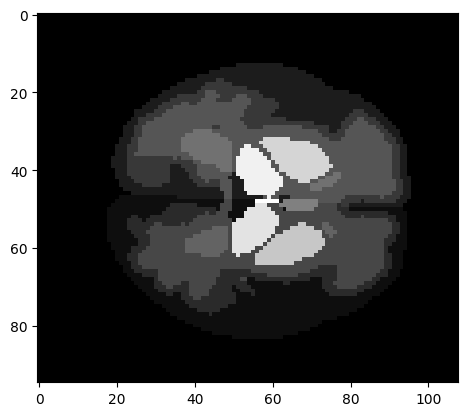

In [7]:
total_volume_ml_hist = []
volume_ml_per_ga = {}

for img_path in brain_images:

    tmp = nib.load(img_path)
    ga = get_ga(img_path)
    if not ga:
        continue

    zooms = tmp.header.get_zooms()
    img = tmp.get_fdata()
    nx,ny,nz = img.shape
    slices = [img[:,:,i] for i in range(nz)]

    total_volume_mm = 0
    for slice in slices:
        mask = slice > 0
        slice_voxels = np.count_nonzero(mask)
        voxel_size = np.prod(zooms)
        slice_volume = slice_voxels * voxel_size
        total_volume_mm += slice_volume

    total_ml = total_volume_mm / 1000

    #otuliers
    if total_ml > 300 and ga < 20:
        print(f"Volume of {img_path.stem} is {total_volume_mm} mm^3")
        plt.imshow(slices[50], cmap="gray")
        plt.show()

    total_volume_ml_hist.append(total_ml)
    volume_ml_per_ga[ga] = volume_ml_per_ga.get(ga, []) + [total_ml]

In [8]:
volume_ml_per_ga_avg = {k: np.mean(v) for k, v in volume_ml_per_ga.items()}

In [9]:
data_x = []
data_y = []
for key, values in volume_ml_per_ga.items():
    for value in values:
        data_x.append(key)
        data_y.append(value)

px.scatter(x=data_x, y=data_y, title="Total Volume vs Gestational Age").show()